# Importing required libraries

In [4]:
import numpy as np
from tqdm import tqdm, trange
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, model_to_dot

In [ ]:
tf.random.set_seed(0)

# Defining Basic Functions



### Preprocessing function

In [ ]:
def normalize(df):
  return (df-df.mean())/df.std()

### Sigmoid Function

In [ ]:
def sigmoid(X):
  '''
  Calculates sigmoid of a vector x.
  '''
  return 1/(1 + np.exp(-X))

### Cost Function

In [ ]:
def cost_func(logits, Y, m):
  eps = 1e-10   #to avoid log(0) : arithmetic error
  cost = -(np.dot(Y,np.log(logits).T)+np.dot((1-Y),np.log(1-logits).T))/m
  cost = np.squeeze(cost)
  cost = cost.item()

  return cost

### One step of gradient descent

In [ ]:
def do_regression(w, b, X, Y, learning_rate):
  m = X.shape[1]
  logits = sigmoid(np.dot(w.T,X)+b)
  cost = cost_func(logits, Y, m)
  b = b - learning_rate*np.sum(logits-Y)/m
  w = w - learning_rate*np.dot(X,(logits-Y).T)/m

  return (w, b, cost)

### Weight Initialization

In [ ]:
def initialize(dims, option = 'zero'):
  np.random.seed(5)
  if(option == 'zero'):                                                #Zero Initialization
    w = np.zeros((dims,1))
  elif(option == 'normal'):
    w = np.random.normal(0.0, 1.0, size= (dims,1))/1.0                 #Gaussian Initialization
  elif(option == 'he'):
    w = np.random.normal(0.0, 1.0, size= (dims,1))*np.sqrt(2/dims)     #He Initialization
  
  b = 0
  assert(w.shape == (dims, 1))
  assert(isinstance(b, float) or isinstance(b, int))
    
  return w,b

In [ ]:
def plot_hist(history):
  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs=range(len(acc)) # Get number of epochs

  #------------------------------------------------
  # Plot training and validation accuracy per epoch
  #------------------------------------------------
  plt.plot(epochs, acc, 'r', label = "Training Accuracy")
  plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
  plt.plot(epochs, loss, 'r', label = "Training Loss")
  plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
  plt.legend()

  plt.title('Training and validation loss')

# Defining the logistic classifier class

In [ ]:
class logistic_classifier:

  def __init__(self, dims, intialization, verbose = False):
    self.w, self.b = initialize(dims, intialization)
    self.costs = []
    self.val_costs = []
    self.acc = []
    self.val_acc = []
    if(intialization == 'zero' and verbose == True):
      print("Weights and Bias initialized based on Zero Initialization with "+str(dims)+" features")
    if(intialization == 'normal' and verbose == True):
      print("Weights and Bias initialized based on Normal Initialization with "+str(dims)+" features")
    if(intialization == 'he' and verbose == True):
      print("Weights and Bias initialized based on He Initialization with "+str(dims)+" features")

  def predict_proba(self, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = self.w.reshape(X.shape[0], 1)
    b = self.b
    logits = sigmoid(np.dot(w.T,X)+b)
    return logits  

  def predict(self, X):
    logits = self.predict_proba(X)
    Y_hat = np.zeros(logits.shape)
    for i in range(logits.shape[1]):
      if logits[0,i] > 0.5:
        Y_hat[0,i] = 1
      else:
        Y_hat[0,i] = 0
    return Y_hat

  def evaluate(self, X, y):
    y_hat = self.predict(X)
    acc_score = accuracy_score(y,y_hat.T)
    f1 = f1_score(y, y_hat.T)
    print('Accuracy on test set: '+str(acc_score*100)+' %')
    print('F1 score on test set: '+str(f1*100)+' %')
    print('\n')

    print('CONFUSION MATRIX\n')
    print(confusion_matrix(y, y_hat.T))
    print('\n')

    print('CLASSIFICATION REPORT\n')
    # target_names = list(class_labels.values())
    print(classification_report(y, y_hat.T))
    print('\n')

  def append_cost(self, cost):
    self.costs.append(cost)

  def append_val_cost(self, cost):
    self.val_costs.append(cost)

  def append_acc(self, acc):
    self.acc.append(acc)

  def append_val_acc(self, acc):
    self.val_acc.append(acc)

  def fit(self, X_train, Y_train, X_val=[], Y_val=[], num_iterations=10000, learning_rate=1e-3, print_loss = True):      
    t = trange(num_iterations)
    for i in t:
      self.w, self.b, train_cost = do_regression(self.w, self.b, X_train, Y_train, learning_rate=learning_rate)
      self.append_cost(train_cost)
      yt_h = self.predict(X_train)
      acc_score = accuracy_score(Y_train, yt_h.T)
      self.append_acc(acc_score)
      if(len(X_val)!=0 and len(Y_val)!=0):
        m = X_val.shape[1]
        val_logits = sigmoid(np.dot(self.w.T,X_val)+self.b)
        val_cost = cost_func(val_logits, Y_val, m)
        self.append_val_cost(val_cost)
        yv_h = self.predict(X_val)
        val_acc_score = accuracy_score(Y_val, yv_h.T)
        self.append_val_acc(val_acc_score)
      if(print_loss==True):
        if(len(X_val)!=0 and len(Y_val)!=0):
          t.set_postfix(loss=-1*train_cost, accuracy = acc_score, val_loss = -1*val_cost, val_accuracy = val_acc_score)
        else:
          t.set_postfix(loss=-1*train_cost, accuracy = acc_score)

# Logistic Regression Model training and testing

## Data Preprocessing

### Reading the data from csv

In [ ]:
df = pd.read_csv('/content/diabetes(1).csv')

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### Storing them as X and Y, along with normalizing X

In [ ]:
x_df = df.drop(['Outcome'], axis=1)

x_df = normalize(x_df)

In [ ]:
y_df = df['Outcome']

### Splitting into train, validation and test

*Train - 60%, Validation - 20%, Test - 20%*

In [ ]:
seed = 82

In [ ]:
X_train, x1, Y_train, y1 = train_test_split(x_df, y_df, test_size = 0.4, stratify = y_df, random_state = seed)
X_val, X_test, Y_val, Y_test = train_test_split(x1, y1, test_size = 0.5, stratify = y1, random_state = seed)

### Converting into numpy arrays

In [ ]:
X_train = X_train.values
Y_train = Y_train.values

In [ ]:
X_val = X_val.values
Y_val = Y_val.values

In [ ]:
X_test = X_test.values
Y_test = Y_test.values

## Grid searching for best hyper-parameters

In [ ]:
lr_list = [1e-1, 1e-2, 1e-3, 1e-4]
epochs_list = [100, 500, 1000, 5000]

In [ ]:
cost_list = []
val_cost_list = []
acc_list = []
val_acc_list = []

In [ ]:
for i in range(4):
  for j in range(4):
    print('Training model with learning rate of '+str(lr_list[j])+' for '+str(epochs_list[i])+' epochs:')
    print('\n')
    dia_clf = logistic_classifier(8, 'he')
    dia_clf.__init__(8, 'he')
    dia_clf.fit(X_train.T, Y_train.T, X_val.T, Y_val.T, learning_rate=lr_list[j], num_iterations=epochs_list[i])
    cost_list.append(dia_clf.costs)
    val_cost_list.append(dia_clf.val_costs)
    acc_list.append(dia_clf.acc)
    val_acc_list.append(dia_clf.val_acc)
    print('\n')

Training model with learning rate of 0.1 for 100 epochs:




100%|██████████| 100/100 [00:00<00:00, 142.19it/s, accuracy=0.763, loss=-.514, val_accuracy=0.786, val_loss=-.508]




Training model with learning rate of 0.01 for 100 epochs:




100%|██████████| 100/100 [00:00<00:00, 157.64it/s, accuracy=0.563, loss=-.756, val_accuracy=0.623, val_loss=-.798]




Training model with learning rate of 0.001 for 100 epochs:




100%|██████████| 100/100 [00:00<00:00, 149.04it/s, accuracy=0.52, loss=-.851, val_accuracy=0.519, val_loss=-.903]




Training model with learning rate of 0.0001 for 100 epochs:




100%|██████████| 100/100 [00:00<00:00, 165.64it/s, accuracy=0.515, loss=-.862, val_accuracy=0.513, val_loss=-.915]




Training model with learning rate of 0.1 for 500 epochs:




100%|██████████| 500/500 [00:03<00:00, 163.64it/s, accuracy=0.772, loss=-.491, val_accuracy=0.779, val_loss=-.461]




Training model with learning rate of 0.01 for 500 epochs:




100%|██████████| 500/500 [00:02<00:00, 174.11it/s, accuracy=0.702, loss=-.569, val_accuracy=0.747, val_loss=-.586]




Training model with learning rate of 0.001 for 500 epochs:




100%|██████████| 500/500 [00:03<00:00, 162.12it/s, accuracy=0.535, loss=-.804, val_accuracy=0.539, val_loss=-.852]




Training model with learning rate of 0.0001 for 500 epochs:




100%|██████████| 500/500 [00:03<00:00, 158.26it/s, accuracy=0.517, loss=-.857, val_accuracy=0.519, val_loss=-.91]




Training model with learning rate of 0.1 for 1000 epochs:




100%|██████████| 1000/1000 [00:05<00:00, 176.74it/s, accuracy=0.774, loss=-.49, val_accuracy=0.773, val_loss=-.461]




Training model with learning rate of 0.01 for 1000 epochs:




100%|██████████| 1000/1000 [00:06<00:00, 158.79it/s, accuracy=0.763, loss=-.514, val_accuracy=0.786, val_loss=-.508]




Training model with learning rate of 0.001 for 1000 epochs:




100%|██████████| 1000/1000 [00:06<00:00, 166.40it/s, accuracy=0.563, loss=-.755, val_accuracy=0.623, val_loss=-.798]




Training model with learning rate of 0.0001 for 1000 epochs:




100%|██████████| 1000/1000 [00:05<00:00, 166.98it/s, accuracy=0.52, loss=-.851, val_accuracy=0.519, val_loss=-.903]




Training model with learning rate of 0.1 for 5000 epochs:




100%|██████████| 5000/5000 [00:30<00:00, 164.54it/s, accuracy=0.774, loss=-.49, val_accuracy=0.773, val_loss=-.461]




Training model with learning rate of 0.01 for 5000 epochs:




100%|██████████| 5000/5000 [00:32<00:00, 156.16it/s, accuracy=0.772, loss=-.491, val_accuracy=0.779, val_loss=-.461]




Training model with learning rate of 0.001 for 5000 epochs:




100%|██████████| 5000/5000 [00:30<00:00, 163.61it/s, accuracy=0.702, loss=-.569, val_accuracy=0.747, val_loss=-.586]




Training model with learning rate of 0.0001 for 5000 epochs:




100%|██████████| 5000/5000 [00:30<00:00, 161.88it/s, accuracy=0.535, loss=-.804, val_accuracy=0.539, val_loss=-.852]

In [ ]:
max_val_acc_list = []
for i in range(len(val_acc_list)):
  max_val_acc_list.append([np.argmax(val_acc_list[i]) ,np.max(val_acc_list[i])])

# max_val_acc_list

max_val_acc_list = np.array(max_val_acc_list)

best_param_index = np.argmax(max_val_acc_list[:,1])
max_val_acc = max_val_acc_list[best_param_index]

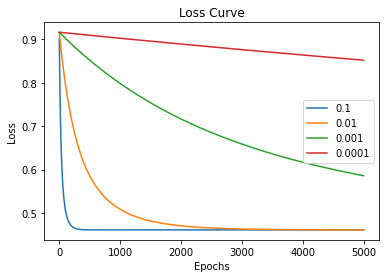

In [ ]:
plt.plot(val_cost_list[12], label = '0.1')
plt.plot(val_cost_list[13], label = '0.01')
plt.plot(val_cost_list[14], label = '0.001')
plt.plot(val_cost_list[15], label = '0.0001')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

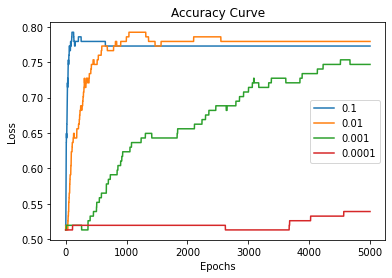

In [ ]:
plt.plot(val_acc_list[12], label = '0.1')
plt.plot(val_acc_list[13], label = '0.01')
plt.plot(val_acc_list[14], label = '0.001')
plt.plot(val_acc_list[15], label = '0.0001')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
best_param_index, max_val_acc

(4, array([103.        ,   0.79220779]))

So, approximately 104 iterations and learning rate as 0.1

## Training the final model and evaluating it on the test set

We'll train the final model for 200 epochs and with 0.1 rate of learning.

In [ ]:
# clf_list[3][3].evaluate(X_test.T, Y_test.T)

In [ ]:
dia_clf = logistic_classifier(8, 'he')
dia_clf.fit(X_train.T, Y_train.T, X_val.T, Y_val.T, learning_rate=0.1, num_iterations=200)

100%|██████████| 200/200 [00:01<00:00, 148.34it/s, accuracy=0.783, loss=-.494, val_accuracy=0.779, val_loss=-.47]


In [ ]:
train_costs = np.array(dia_clf.costs)
val_costs = np.array(dia_clf.val_costs)

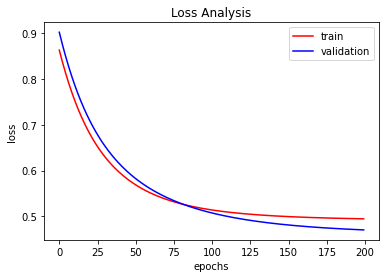

In [ ]:
plt.plot(train_costs, color = 'r', label = 'train')
plt.plot(val_costs, color = 'b', label = 'validation')
plt.title('Loss Analysis')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
train_acc = np.array(dia_clf.acc)
val_acc = np.array(dia_clf.val_acc)

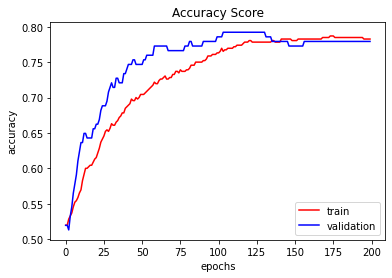

In [ ]:
plt.plot(train_acc, color = 'r', label = 'train')
plt.plot(val_acc, color = 'b', label = 'validation')
plt.title('Accuracy Score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
dia_clf.evaluate(X_test.T, Y_test.T)

Accuracy on test set: 77.92207792207793 %
F1 score on test set: 62.22222222222222 %


CONFUSION MATRIX

[[92  8]
 [26 28]]


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       100
           1       0.78      0.52      0.62        54

    accuracy                           0.78       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.78      0.77       154





So an accuracy of 77.92% and an f1-score of 76.62%

# Neural Network Building

Utility function to evaluate the neural network models

In [ ]:
def evaluate_model(model, X, Y):
  y_metrics = model.evaluate(X, Y, verbose = 0)
  y_pred = model.predict(X, verbose = 0)
  y_pred[y_pred>=0.5] = 1
  y_pred[y_pred<0.5] = 0
  # acc = accuracy_score(Y, y_pred)
  f1 = f1_score(Y, y_pred)
  print('Accuracy on test set: '+str(y_metrics[1]*100)+' %')
  print('F1 score on test set: '+str(f1*100)+' %')
  print('\n')

  print('CONFUSION MATRIX\n')
  print(confusion_matrix(Y, y_pred))
  print('\n')

  print('CLASSIFICATION REPORT\n')
  # target_names = list(class_labels.values())
  print(classification_report(Y, y_pred))
  print('\n')

### Defining the base architecture

Building models with a simple 2 hidden layer architecture with dense layers and sigmoid/relu activations but with 3 *regularization* techniques, L1, L2, Dropout.

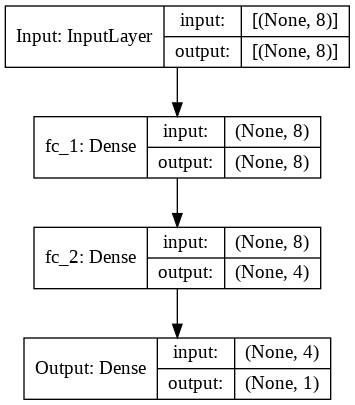



### Choosing the right activation function

I train a base model for 100 epochs on with hidden layers having either ReLU activations and Sigmoid activations

Defining the Sigmoid and Relu based models

In [2]:
def base_model_sigmoid(input_shape):
  X_input = Input(shape=input_shape, name = 'Input')

  X = Dense(8, 'sigmoid', name = 'fc_1')(X_input)
  X = Dense(4, 'sigmoid', name = 'fc_2')(X)
  out = Dense(1, 'sigmoid', name = 'Output')(X)

  model = Model(X_input, out, name='base_nn_sg')

  return model

In [3]:
def base_model_relu(input_shape):
  X_input = Input(shape=input_shape, name = 'Input')

  X = Dense(8, 'relu', name = 'fc_1')(X_input)
  X = Dense(4, 'relu', name = 'fc_2')(X)
  out = Dense(1, 'sigmoid', name = 'Output')(X)

  model = Model(X_input, out, name='base_nn_relu')

  return model

In [ ]:
base_nn_relu = base_model_relu((8))

base_nn_relu.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics = ['accuracy'])

hist_base_relu = base_nn_relu.fit(x = X_train, y = Y_train, validation_data= (X_val, Y_val), epochs = 100, verbose=0)

In [ ]:
base_nn_sg = base_model_sigmoid((8))

base_nn_sg.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics = ['accuracy'])

hist_base_sigmoid = base_nn_sg.fit(x = X_train, y = Y_train, validation_data= (X_val, Y_val), epochs = 100, verbose=0)

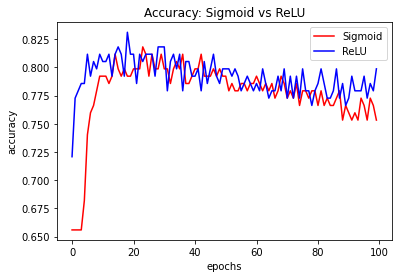

In [ ]:
sg_acc = hist_base_sigmoid.history['val_accuracy']
relu_acc = hist_base_relu.history['val_accuracy']
sg_loss = hist_base_sigmoid.history['val_loss']
relu_loss = hist_base_relu.history['val_loss']

plt.plot(sg_acc, color = 'r', label = 'Sigmoid')
plt.plot(relu_acc, color = 'b', label = 'ReLU')
plt.title('Accuracy: Sigmoid vs ReLU')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()



### L1 Regularization

All the experimental results are provided in the report. The code below is for the final model training. **Regularization parameter is *0.01*.**

In [ ]:
def l1_nn(input_shape):
  X_input = Input(shape=input_shape)

  reg = tf.keras.regularizers.L1L2(l1=0.01,l2=0)

  X = Dense(8, 'relu', kernel_regularizer=reg, name = 'fc_1')(X_input)
  X = Dense(4, 'relu', kernel_regularizer=reg, name = 'fc_2')(X)
  out = Dense(1, 'sigmoid', name = 'Output')(X)

  model = Model(X_input, out, name='l1_nn')

  return model


In [ ]:
l1_model = l1_nn((8))

In [ ]:
l1_model.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics = ['accuracy'])

In [ ]:
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='./l1_model/weights/model_l1.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./l1_model/logs'),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20),
    tf.keras.callbacks.ReduceLROnPlateau()
]

In [ ]:
hist_l1 = l1_model.fit(x = X_train, y = Y_train, validation_data= (X_val, Y_val), epochs = 5000, verbose='auto', callbacks=my_callbacks)

Epoch 1/5000
15/15 [==============================] - 1s 20ms/step - loss: 0.9870 - accuracy: 0.4826 - val_loss: 0.8439 - val_accuracy: 0.7143
Epoch 2/5000
15/15 [==============================] - 0s 3ms/step - loss: 0.8072 - accuracy: 0.6543 - val_loss: 0.7550 - val_accuracy: 0.6818
Epoch 3/5000
15/15 [==============================] - 0s 3ms/step - loss: 0.7305 - accuracy: 0.6609 - val_loss: 0.6868 - val_accuracy: 0.7078
Epoch 4/5000
15/15 [==============================] - 0s 4ms/step - loss: 0.6793 - accuracy: 0.6739 - val_loss: 0.6345 - val_accuracy: 0.7208
Epoch 5/5000
15/15 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.7022 - val_loss: 0.5882 - val_accuracy: 0.7792
Epoch 6/5000
15/15 [==============================] - 0s 5ms/step - loss: 0.5974 - accuracy: 0.7652 - val_loss: 0.5661 - val_accuracy: 0.7922
Epoch 7/5000
15/15 [==============================] - 0s 5ms/step - loss: 0.5746 - accuracy: 0.7609 - val_loss: 0.5529 - val_accuracy: 0.7922
Epoch

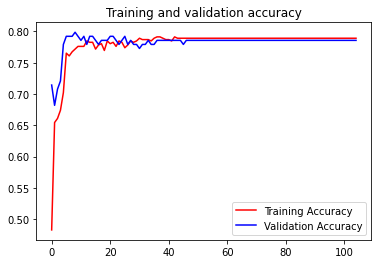

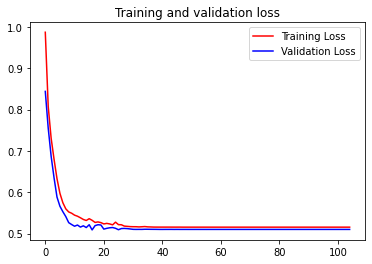

In [ ]:
plot_hist(hist_l1)

In [ ]:
# l1_model.load_weights('/content/l1_model/weights/model_l1.08-0.58.h5')

In [ ]:
evaluate_model(l1_model, X_test, Y_test)

Accuracy on test set: 76.6233742237091 %
F1 score on test set: 63.26530612244898 %


CONFUSION MATRIX

[[87 13]
 [23 31]]


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       100
           1       0.70      0.57      0.63        54

    accuracy                           0.77       154
   macro avg       0.75      0.72      0.73       154
weighted avg       0.76      0.77      0.76       154





### L2 Regularization

All the experimental results are provided in the report. The code below is for the final model training. **Regularization parameter is *0.01*.**

In [ ]:
def l2_nn(input_shape):
  X_input = Input(shape=input_shape)

  # reg = tf.keras.regularizers.L1L2(l1=0,l2=0.01)

  X = Dense(8, 'relu', kernel_regularizer='l2', name = 'fc_1')(X_input)
  X = Dense(4, 'relu', kernel_regularizer='l2', name = 'fc_2')(X)
  out = Dense(1, 'sigmoid')(X)

  model = Model(X_input, out, name='l2_nn')

  return model

In [ ]:
l2_model = l2_nn((8))

In [ ]:
l2_model.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics = ['accuracy'])

In [ ]:
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='./l2_model/weights/model_l2.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./l2_model/logs'),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20),
    tf.keras.callbacks.ReduceLROnPlateau()
]

In [ ]:
hist_l2 = l2_model.fit(x = X_train, y = Y_train, validation_data= (X_val, Y_val), epochs = 5000, verbose=1, callbacks=my_callbacks)

Epoch 1/5000
15/15 [==============================] - 1s 20ms/step - loss: 0.9345 - accuracy: 0.4804 - val_loss: 0.7703 - val_accuracy: 0.6234
Epoch 2/5000
15/15 [==============================] - 0s 5ms/step - loss: 0.7387 - accuracy: 0.6283 - val_loss: 0.6738 - val_accuracy: 0.7013
Epoch 3/5000
15/15 [==============================] - 0s 4ms/step - loss: 0.6574 - accuracy: 0.6652 - val_loss: 0.6179 - val_accuracy: 0.7078
Epoch 4/5000
15/15 [==============================] - 0s 4ms/step - loss: 0.6084 - accuracy: 0.7065 - val_loss: 0.5862 - val_accuracy: 0.7338
Epoch 5/5000
15/15 [==============================] - 0s 4ms/step - loss: 0.5758 - accuracy: 0.7609 - val_loss: 0.5563 - val_accuracy: 0.7727
Epoch 6/5000
15/15 [==============================] - 0s 5ms/step - loss: 0.5529 - accuracy: 0.7674 - val_loss: 0.5488 - val_accuracy: 0.7922
Epoch 7/5000
15/15 [==============================] - 0s 4ms/step - loss: 0.5364 - accuracy: 0.7804 - val_loss: 0.5233 - val_accuracy: 0.7922
Epoch

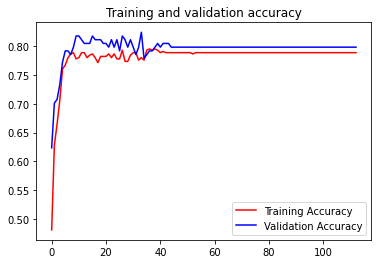

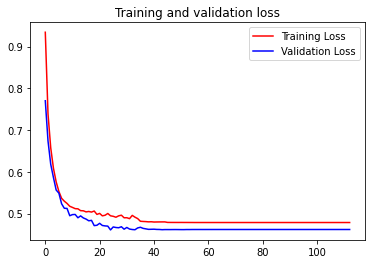

In [ ]:
plot_hist(hist_l2)

In [ ]:
# l2_model.load_weights('/content/l2_model/weights/model_l2.40-0.47.h5')

In [ ]:
evaluate_model(l2_model, X_test, Y_test)

Accuracy on test set: 77.92207598686218 %
F1 score on test set: 65.3061224489796 %


CONFUSION MATRIX

[[88 12]
 [22 32]]


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.73      0.59      0.65        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154





## Part 3: Bonus : Dropout

Architecture :

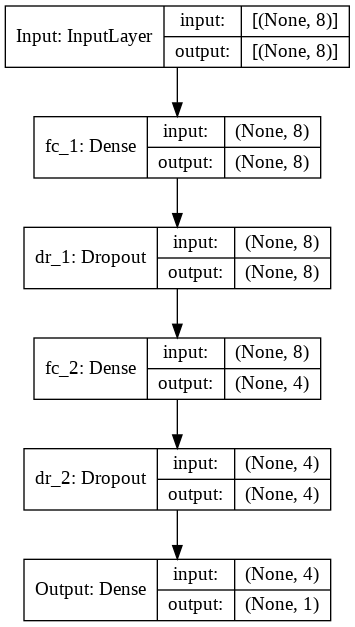

In [8]:
def dropout_nn(input_shape):
  X_input = Input(shape=input_shape,  name = 'Input')

  X = Dense(8, 'relu', name = 'fc_1')(X_input)
  X = Dropout(0.125, name= 'dr_1')(X)
  X = Dense(4, 'relu', name = 'fc_2')(X)
  X = Dropout(0.25, name = 'dr_2')(X)
  out = Dense(1, 'sigmoid', name = 'Output')(X)

  model = Model(X_input, out, name='drop_nn')

  return model

In [9]:
dropout_model = dropout_nn((8))

In [ ]:
dropout_model.compile(loss = 'binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.01), metrics = ['accuracy'])

In [ ]:
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='./dropout_model/weights/model_dropout.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./dropout_model/logs'),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20),
    tf.keras.callbacks.ReduceLROnPlateau()
]

In [ ]:
hist_dropout = dropout_model.fit(x = X_train, y = Y_train, validation_data= (X_val, Y_val), epochs = 5000, verbose='auto', callbacks=my_callbacks)

Epoch 1/5000
15/15 [==============================] - 1s 22ms/step - loss: 0.6964 - accuracy: 0.5696 - val_loss: 0.6246 - val_accuracy: 0.6948
Epoch 2/5000
15/15 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6239 - val_loss: 0.5837 - val_accuracy: 0.6753
Epoch 3/5000
15/15 [==============================] - 0s 4ms/step - loss: 0.5796 - accuracy: 0.6913 - val_loss: 0.5259 - val_accuracy: 0.7597
Epoch 4/5000
15/15 [==============================] - 0s 3ms/step - loss: 0.5584 - accuracy: 0.7109 - val_loss: 0.4834 - val_accuracy: 0.7727
Epoch 5/5000
15/15 [==============================] - 0s 5ms/step - loss: 0.5490 - accuracy: 0.7109 - val_loss: 0.4684 - val_accuracy: 0.7792
Epoch 6/5000
15/15 [==============================] - 0s 4ms/step - loss: 0.5497 - accuracy: 0.7217 - val_loss: 0.4672 - val_accuracy: 0.7792
Epoch 7/5000
15/15 [==============================] - 0s 4ms/step - loss: 0.5246 - accuracy: 0.7370 - val_loss: 0.4612 - val_accuracy: 0.7987
Epoch

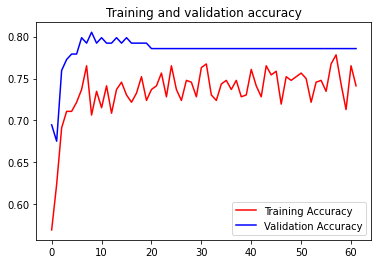

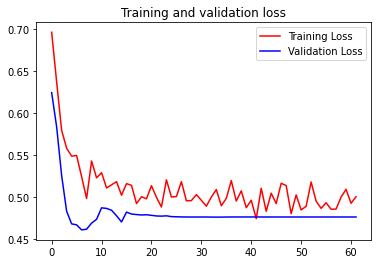

In [ ]:
plot_hist(hist_dropout)

In [ ]:
evaluate_model(dropout_model, X_test, Y_test)

Accuracy on test set: 78.57142686843872 %
F1 score on test set: 65.26315789473684 %


CONFUSION MATRIX

[[90 10]
 [23 31]]


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       100
           1       0.76      0.57      0.65        54

    accuracy                           0.79       154
   macro avg       0.78      0.74      0.75       154
weighted avg       0.78      0.79      0.78       154



